# PROJECT: GAN chess piece creation
From my screenshot to FEN project (dataset: https://www.kaggle.com/koryakinp/chess-positions), I initially split the project into 2: 
- Piece detection.
- Piece colour detection.

In the end I went back to the base CNN and changed a few things which lead to the accuracy I was looking for.
For the piece detection section, I used open-cvs canny edge detection algorithm to binorise the sqaure images of the pieces. Leaving lots of pretty piece edges. 

After not having to use them (even though they lead to great accuracy of piece prediction in a CNN) I didn't want them to go to waste. The idea of creating GAN generated pieces came to mind, with the edge dataset being perfect for this task.

In this project, I get a generating CNN model that can create piece outlines that fool the discriminating CNN model.

## Loading libraries

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
from pathlib import Path
from PIL import Image
import cv2
import time
from IPython import display
from PIL import Image

## Initialising parameters

In [6]:
img_width, img_height = 400, 400    
square_width = img_width // 8
square_height = img_height // 8
border_crop_px = 3
sq_wdth = square_width - 2*border_crop_px
sq_hgt = square_height - 2*border_crop_px

## Creating functions for image pre-processing

In [7]:
def square_extractor(img):
# taking our edged board as input, splitting it into 64 squares and then removing a 2px border, returning the 64 cropped 
# squares

    # splitting image into 8 equal rows
    rows = [img[i-square_height:i,:] for i in np.arange(square_height, img_height+square_height, square_height)]
    # splitting individual rows into squares
    squares = [j[:,i-square_width:i] for j in rows for i in np.arange(square_width,img_width+square_width, square_width)] 
    # cropping 2 pixels off each 50x50 image to get rid of the square borders  
    squares = [i[border_crop_px:square_width-border_crop_px,border_crop_px:square_height-border_crop_px] for i in squares] 
    
    return squares

In [8]:
def load_preprocess_square_images(img):
    # reading our image, sending back an Grayscale of each square (with 2px border crop) on the board
    # returning matrix of shape => 64x44x44x1   
    
    img = cv2.imread(img,0) # read image as black and white
    img = cv2.blur(img,(2,2)) # applying Gaussian blur to smooth the images noise
    img = cv2.resize(img, (img_width, img_height)) 
    img = cv2.Canny(img, 100, 200) # edge detection algorithm   
    img = np.float32(img) / 255.0 # To keep the image values between 0 and 1
    squares = square_extractor(img)
    
    return squares

### Even though at first glace the FEN may be uneccesary, it will be useful in selecting certain pieces for our dataset.

### FEN generating functions

In [9]:
def space_characterizor(rank):
    # using our FEN notation to create an 1x8 chess row matrix, mainting FEN notation for pieces
    # replacing empty squares by 'o'
    
    # creating our nx1 'rank'
    broken_pieces = [i for i in rank]
    for i, j in enumerate(broken_pieces):
        try:
            # as numbers denote empty spaces we replace the int by that no of 'o'
            broken_pieces[i] = 'o' * int(j)
        except:
            continue
    # joining all our text to create a 8 character row        
    rank = ''.join(broken_pieces)
    return rank

In [10]:
def fen_to_numeric(all_fen):
    
    piece_numeric = {'o':0,'p':1,'b':2,'r':3,'n':4,'k':5,'q':6,'P':7,'B':8,'R':9,'N':10,'K':11,'Q':12}
    # splitting our fen into rows
    broken_fen = re.split(r'-/?', all_fen)
    # creating a 8x8 board matrix from each row
    broken_rows = [space_characterizor(i) for i in broken_fen]
    # replacing each character with its equivalent number and flattening to a 1x64 vector
    fen_board = [piece_numeric[str(i)] for i in np.array([list(i) for i in broken_rows]).flatten()]
    return np.array(fen_board)

In [11]:
def get_key(val): 
    piece_numeric = {'o':0,'p':1,'b':2,'r':3,'n':4,'k':5,'q':6,'P':7,'B':8,'R':9,'N':10,'K':11,'Q':12}
    for key, value in piece_numeric.items(): 
         if val == value: 
            return key 

## Loading the dataset

### Collab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

train_set = Path("/content/drive/My Drive/Project_Jedha/test")

all_image_paths = [str(img_path) for img_path in train_set.glob("*.jpeg")]
print(all_image_paths[:5])
all_image_fen = [re.search(r'test/(.*?).jpeg',i).group(1) for i in all_image_paths]
print(all_image_fen[:5])

### Local

In [3]:
train_set = Path(r"C:\Users\alecp\Desktop\FINAL_PROJECT\Datasets\train")

all_image_paths = [str(img_path) for img_path in train_set.glob("*.jpeg")]
print(f'path: {all_image_paths[0]}')
all_image_fen = [re.search(r'train\\(.*?).jpeg',i).group(1) for i in all_image_paths]
print(f'board FEN: {all_image_fen[0]}')

path: C:\Users\alecp\Desktop\FINAL_PROJECT\Datasets\train\1b1B1b2-2pK2q1-4p1rB-7k-8-8-3B4-3rb3.jpeg
board FEN: 1b1B1b2-2pK2q1-4p1rB-7k-8-8-3B4-3rb3


## Creating Dataset

In [14]:
sample_size = 50

In [25]:
# creating our target variable from the fen in shape = (sample_size * 64, 1)
target = np.array([fen_to_numeric(i) for i in all_image_fen[:sample_size]]).flatten()
print(f'target (FEN) shape 64*{sample_size}: {target.shape}')
# creating our squares of shape sample_sizex64x46x46x3
squares_images = [load_preprocess_square_images(i) for i in all_image_paths[:sample_size]]
print(f'B&W squares of {sq_hgt}x{sq_wdth}, dataset shape: ({sample_size}, {np.array(squares_images[0]).shape}')

# reshaping to place into dataframe with shape = (64*sample_size, 46*46*3)
squares_images = tf.reshape(squares_images, (-1, (sq_hgt*sq_wdth)))
print(f'resized "flattened" squares shape {sample_size}*64, {sq_hgt}*{sq_wdth}: {squares_images.shape}')

target (FEN) shape 64*50: (3200,)
B&W squares of 44x44, dataset shape: (50, (64, 44, 44)
resized "flattened" squares shape 50*64, 44*44: (3200, 1936)


In [28]:
# keeping 'square_images' as our complete dataset and 'squares' being the filtered dataset, meaning there is no 
# need to reload the images into google collab as this was the longest step

drop_ds = pd.DataFrame([target, squares_images]).transpose().rename({0: 'target', 1: 'squares'}, axis = 1)
print('incl empty squares dataframe size: ',drop_ds.shape)
drop_ds = drop_ds[(drop_ds.target != 0)] # remove or select a certain piece/ pieces to create our ds
print('excl empty squares dataframe size: : ',drop_ds.shape)

incl empty squares dataframe size:  (3200, 2)
excl empty squares dataframe size: :  (632, 2)


In [29]:
squares = [drop_ds.squares.iloc[i] for i in range(len(drop_ds.squares))]
squares = tf.reshape(squares, (-1, sq_wdth, sq_hgt, 1))

init units for model: 11.0
shape of batch: (64, 44, 44, 1)


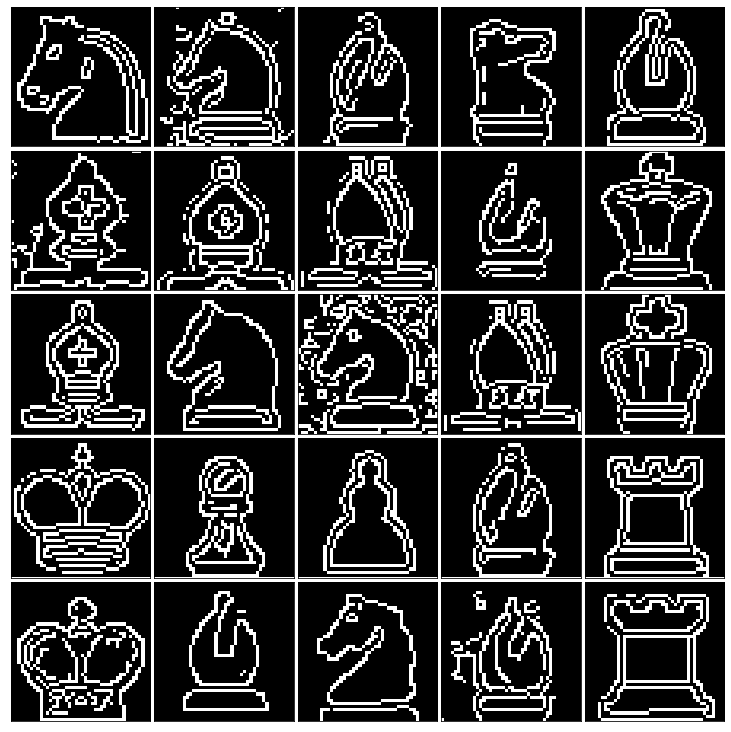

<Figure size 720x360 with 0 Axes>

In [40]:
BUFFER_SIZE = squares.shape[0]
BATCH_SIZE = 64
init_units = squares.shape[1]/4
train_set = tf.data.Dataset.from_tensor_slices(squares).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(f'init units for model: {init_units}')
for i in train_set.take(1):
    print(f'shape of batch: {i.shape}')
    fig, axs = plt.subplots(5, 5, squeeze = True, figsize = (10,10))
    plt.figure(figsize = (10,5))
    for k in range(5 * 5):
        m = k // 5
        n = k % 5
        axs[n,m].imshow(tf.squeeze(i[k]), cmap = 'gray')
        axs[n,m].set_xticks(())
        axs[n,m].set_yticks(())
    fig.tight_layout(pad = 0.1)
    plt.show()

## Creating Generative Adversarial Network

In [61]:
# Simple CNN generator starting from 256 11x11 'feature maps' / canvas's that the generator can paint on
# outputting an image of shape 44 x 44 

def generator_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(11*11*256, use_bias=False, input_shape=(100,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(alpha = 0.2),
        
        tf.keras.layers.Reshape((11,11, 256)),
        
        tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(1, 1), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(alpha = 0.2),
        
        tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(alpha = 0.2),
        
        tf.keras.layers.Conv2DTranspose(1, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation="tanh")
                                ])
    return model

In [62]:
generator = generator_model()

In [63]:
generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 30976)             3097600   
_________________________________________________________________
batch_normalization_3 (Batch (None, 30976)             123904    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 30976)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 11, 11, 256)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 11, 11, 128)       524288    
_________________________________________________________________
batch_normalization_4 (Batch (None, 11, 11, 128)       512       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 11, 11, 128)      

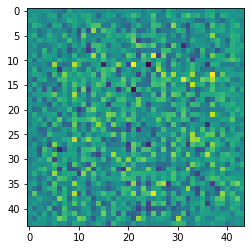

In [64]:
# checking that the generator works to create an image from noise
random_pixels = tf.random.normal([1,100])

rand_img = generator(random_pixels, training=False)

plt.imshow(rand_img.numpy().squeeze())
plt.show()

In [65]:
# Simple binary classification CNN discriminator with input image of shape 44 x 44

def make_discriminator_model():
  
    model = tf.keras.Sequential([
        
        tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[44, 44, 1]),
        tf.keras.layers.LeakyReLU(alpha = 0.2),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha = 0.2),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])

    return model 

In [66]:
# testing the discriminator, on the prediction of our noise image (given that no training has happened yet)
discriminator = make_discriminator_model()
discriminator(rand_img, training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5002635]], dtype=float32)>

In [67]:
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 22, 22, 64)        640       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 11, 11, 128)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 11, 11, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 15488)            

In [68]:
# defining our loss function with Binary Crossentropy
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [69]:
def discriminator_loss(real_outputs, fake_outputs):
# taking probability of descrims decision, checking how accurate it was and sending back total_loss
# min loss => come from maximising correct predictions between fake and real

    # Calculating the loss between the real images and 1 (how well can the model predict 'real')
    real_loss = cross_entropy(tf.ones_like(real_outputs), real_outputs)
    # Calculating the loss between the generated images and 0 (how well can the model predict 'fake')
    fake_loss = cross_entropy(tf.zeros_like(fake_outputs), fake_outputs)
    # both are equally important for the discrim to become better at differentiating the two
    total_loss = real_loss + fake_loss 

    return total_loss

In [70]:
def generator_loss(fake_outputs):
# taking the probability of the dicriminators decision on the generated images
# min loss => maximising the error the discrim makes on the generated images being real

    return cross_entropy(tf.ones_like(fake_outputs), fake_outputs)

In [71]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

In [72]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16
# seed used as starting noise as input for the generator to create our images during training
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [73]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True) # generate images from noise

        real_output = discriminator(images, training=True) # prediction of discrim on real images
        fake_output = discriminator(generated_images, training=True) # prediction of discrim on generated images

        gen_loss = generator_loss(fake_output) # calculating gen loss
        disc_loss = discriminator_loss(real_output, fake_output) # calculating discrim loss

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) # creating gradient changes needed for 
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables) # each 'training variable'

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) # applying calculated
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # gradient changes

In [74]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('./GAN_imgs/GAN_pawn/GAN_img_at_epoch_{:04d}.png'.format(epoch)) # saving an image for each EPOCH
    plt.show()

## Running model & compiling results

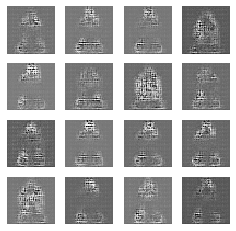

In [78]:
for epoch in range(EPOCHS):
    start = time.time()

    for image_batch in train_set:
        train_step(image_batch)

    # removing the last saved image and replacing it with the new one
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                          epoch + 1,
                          seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

# Generating the last image created by our GAN
display.clear_output(wait=True)
generate_and_save_images(generator,
                         EPOCHS,
                         seed)

<class 'numpy.ndarray'>


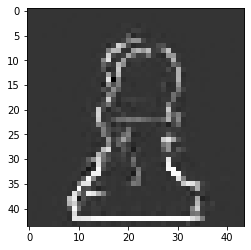

<class 'numpy.ndarray'>


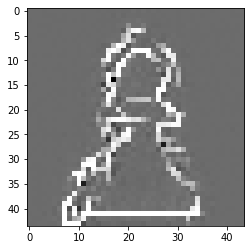

<class 'numpy.ndarray'>


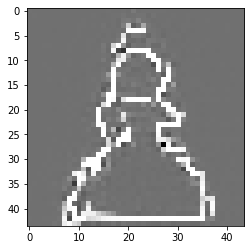

<class 'numpy.ndarray'>


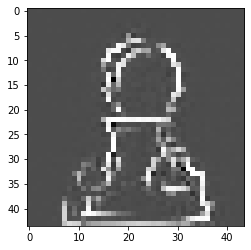

<class 'numpy.ndarray'>


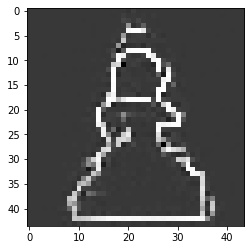

<class 'numpy.ndarray'>


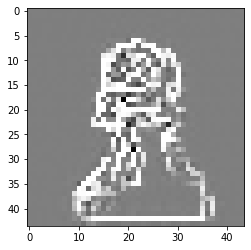

<class 'numpy.ndarray'>


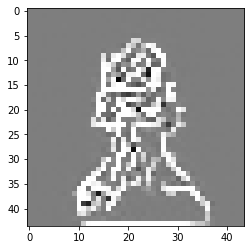

<class 'numpy.ndarray'>


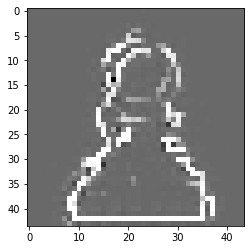

<class 'numpy.ndarray'>


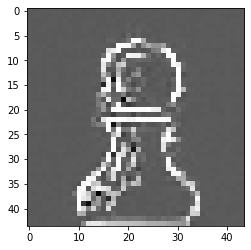

<class 'numpy.ndarray'>


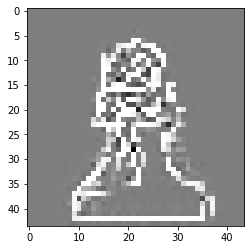

<class 'numpy.ndarray'>


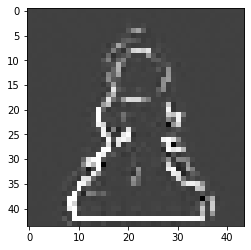

<class 'numpy.ndarray'>


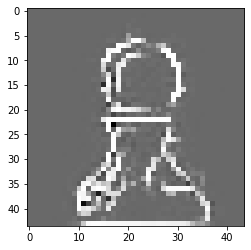

<class 'numpy.ndarray'>


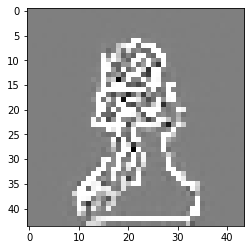

<class 'numpy.ndarray'>


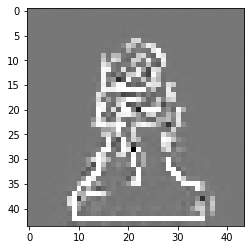

<class 'numpy.ndarray'>


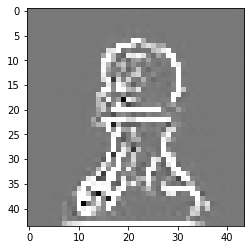

<class 'numpy.ndarray'>


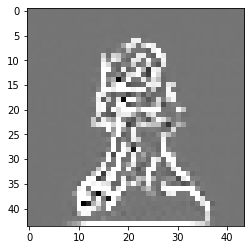

In [288]:
predictions = generator(seed, training=False)

for i in range(predictions.shape[0]):
    gan_img = np.float32(predictions[i,:,:,0] * 127.5 + 127.5)
    plt.imshow(gan_img, cmap = 'gray')
    plt.show()

In [9]:
# if images selected for each piece and progression saved in different subfolders
# this for loop creates a GIF for eachs piece's generation
for i in ['GAN_pawn','GAN_rook','GAN_knights','GAN_king','GAN_queen','GAN_bishop']:

    img, *imgs = [Image.open(f) for f in [f'./GAN_imgs/{i}/GAN_img_at_epoch_{str(num).zfill(4)}.png' for num in range(1,EPOCHS+1)]]
    img.save(fp=f"./{i}.gif", format='GIF', append_images=imgs,
             save_all=True, duration=100, loop=0)

In [290]:
# for downloading files from google collab
!zip -r /content/file.zip /content/GAN_pawn
from google.colab import files
files.download("/content/file.zip")

updating: content/GAN_pawn/ (stored 0%)
updating: content/GAN_pawn/GAN_img_at_epoch_0272.png (deflated 7%)
updating: content/GAN_pawn/GAN_img_at_epoch_0255.png (deflated 7%)
updating: content/GAN_pawn/GAN_img_at_epoch_0233.png (deflated 7%)
updating: content/GAN_pawn/GAN_img_at_epoch_0132.png (deflated 7%)
updating: content/GAN_pawn/GAN_img_at_epoch_0072.png (deflated 6%)
updating: content/GAN_pawn/GAN_img_at_epoch_0096.png (deflated 7%)
updating: content/GAN_pawn/GAN_img_at_epoch_0095.png (deflated 7%)
updating: content/GAN_pawn/GAN_img_at_epoch_0026.png (deflated 9%)
updating: content/GAN_pawn/GAN_img_at_epoch_0083.png (deflated 8%)
updating: content/GAN_pawn/GAN_img_at_epoch_0122.png (deflated 7%)
updating: content/GAN_pawn/GAN_img_at_epoch_0297.png (deflated 6%)
updating: content/GAN_pawn/GAN_img_at_epoch_0224.png (deflated 7%)
updating: content/GAN_pawn/GAN_img_at_epoch_0002.png (deflated 11%)
updating: content/GAN_pawn/GAN_img_at_epoch_0227.png (deflated 7%)
updating: content/GAN

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>